In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
%cd /usr/local/

!rm -rf cuda

!ln -s /usr/local/cuda-10.1 /usr/local/cuda

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-m5cpleg5
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-m5cpleg5
directory /content/src already exists
Out bin /content/result.out
/usr/local


In [ ]:
!stat cuda

!nvidia-smi

  File: cuda -> /usr/local/cuda-10.1
  Size: 20        	Blocks: 0          IO Block: 4096   symbolic link
Device: 24h/36d	Inode: 2621444     Links: 1
Access: (0777/lrwxrwxrwx)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2022-02-09 20:14:46.233818640 +0000
Modify: 2022-02-09 20:14:46.107818785 +0000
Change: 2022-02-09 20:14:46.107818785 +0000
 Birth: -
Wed Feb  9 20:14:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:

### Poniżej jest cudaMalloc

In [ ]:
%%writefile test.cu
#include <cuda_runtime_api.h>
#include <cstdlib>
#include <iostream>
#include <fstream>
#include <string>
#include <time.h>


__device__ 
int getAgent(int x, int y, int width, int* cudaBoard) {
    return cudaBoard[y*width+x];
}

__device__
int calculateNeighbours(int x, int y, int width, int height, int *cudaBoard) {
    int n = 0;

    n += getAgent((x+width-1)%width, (y+height-1)%height, width, cudaBoard); // x-1, y-1
    n += getAgent(x, (y+height-1)%height, width, cudaBoard);                 // x,   y-1
    n += getAgent((x+1)%width, (y+height-1)%height, width, cudaBoard);       // x+1, y-1

    n += getAgent((x+width-1)%width, y, width, cudaBoard);                   // x-1, y
    n += getAgent((x+1)%width, y, width, cudaBoard);                         // x+1, y

    n += getAgent((x+width-1)%width, (y+1)%height, width, cudaBoard);        // x-1, y+1
    n += getAgent(x, (y+1)%height, width, cudaBoard);                        // x,   y+1
    n += getAgent((x+1)%width, (y+1)%height, width, cudaBoard);              // x+1, y+1

    return n;
}

__global__
void runGeneration(int width, int height, int *cudaBoardOld, int *cudaBoardNew) {
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;

    for(int i=index; i < width*height; i += stride) {
        int x = i%width;
        int y = i/width;

        int state = cudaBoardOld[i];
        int neighbours = calculateNeighbours(x, y, width, height, cudaBoardOld);
        
        
        if(state == 0 && neighbours == 3) {
            cudaBoardNew[i] = 1;
            continue;
        }
        if(state == 1 && (!(neighbours == 2 || neighbours == 3))) {
            cudaBoardNew[i] = 0;
            continue;
        }
        cudaBoardNew[i] = cudaBoardOld[i];
    }
}


void initializeBoard(int width, int height, int *board) {
    for(int i=0; i<width*height; ++i) 
        board[i] = rand() % 2;
}

void saveBoard(std::string name, int *localBoard, int width, int height) {
    std::ofstream MyFile(name);

    for(int x=0; x<width; ++x) {
        for(int y=0; y<height; ++y) {
            if(y != height-1)
                MyFile << localBoard[y*width+x] << ", ";
            else
                MyFile << localBoard[y*width+x];
        }
        MyFile << "\n";
    }

    MyFile.close();
}

int main(int argc, char** argv) {
    srand (time(NULL));
    int width = atoi(argv[2]);
    int height = atoi(argv[3]);
    int generations = atoi(argv[1]);
    int *cudaBoardOld, *cudaBoardNew, *localBoard;

    localBoard = new int[width*height];
    initializeBoard(width, height, localBoard);

    saveBoard("start.txt", localBoard, width, height);
    
    cudaMalloc(&cudaBoardOld, width*height*sizeof(int));
    cudaMalloc(&cudaBoardNew, width*height*sizeof(int));
    cudaMemcpy(cudaBoardOld, localBoard, width*height*sizeof(int), cudaMemcpyHostToDevice);

    int blockSize = 256;
    int numBlocks = (width*height + blockSize - 1) / blockSize;

    for(int i=0; i<generations; ++i) {
        runGeneration<<<numBlocks, blockSize>>>(width, height, cudaBoardOld, cudaBoardNew);
        cudaDeviceSynchronize();
        
        int *temp = cudaBoardOld;
        cudaBoardOld = cudaBoardNew;
        cudaBoardNew = temp;
    }

    cudaMemcpy(localBoard, cudaBoardOld, width*height*sizeof(int), cudaMemcpyDeviceToHost);

    saveBoard("end.txt", localBoard, width, height);
    

    cudaFree(cudaBoardOld);
    cudaFree(cudaBoardNew);
    delete[] localBoard;

    return 0;
}

Overwriting test.cu


In [ ]:
%%bash

nvcc --std=c++11 test.cu -o test

In [ ]:
%%bash
./test 100000 200 200

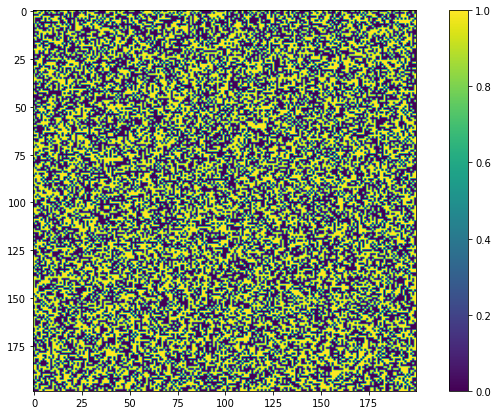

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('start.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

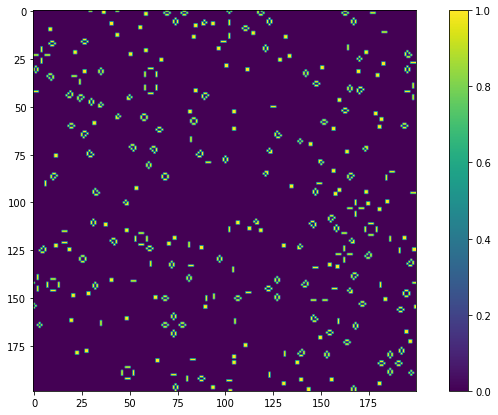

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('end.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

In [ ]:
%%bash

nvprof ./test 100000 200 200

==514== NVPROF is profiling process 514, command: ./test 100000 200 200
==514== Profiling application: ./test 100000 200 200
==514== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  1.27136s    100000  12.713us  12.415us  19.584us  runGeneration(int, int, int*, int*)
                    0.00%  25.856us         1  25.856us  25.856us  25.856us  [CUDA memcpy HtoD]
                    0.00%  24.480us         1  24.480us  24.480us  24.480us  [CUDA memcpy DtoH]
      API calls:   73.47%  2.15198s    100000  21.519us  2.5940us  1.9935ms  cudaDeviceSynchronize
                   19.90%  582.71ms    100000  5.8270us  3.8820us  1.9513ms  cudaLaunchKernel
                    6.59%  193.02ms         2  96.510ms  4.7700us  193.01ms  cudaMalloc
                    0.02%  492.73us         1  492.73us  492.73us  492.73us  cuDeviceTotalMem
                    0.01%  287.76us         2  143.88us  24.068us  263.69us  cudaFree
 

### Poniżej jest cudaMallocHost

In [ ]:
%%writefile test2.cu
#include <cuda_runtime_api.h>
#include <cstdlib>
#include <iostream>
#include <fstream>
#include <string>
#include <time.h>


__device__ 
int getAgent(int x, int y, int width, int* cudaBoard) {
    return cudaBoard[y*width+x];
}

__device__
int calculateNeighbours(int x, int y, int width, int height, int *cudaBoard) {
    int n = 0;

    n += getAgent((x+width-1)%width, (y+height-1)%height, width, cudaBoard); // x-1, y-1
    n += getAgent(x, (y+height-1)%height, width, cudaBoard);                 // x,   y-1
    n += getAgent((x+1)%width, (y+height-1)%height, width, cudaBoard);       // x+1, y-1

    n += getAgent((x+width-1)%width, y, width, cudaBoard);                   // x-1, y
    n += getAgent((x+1)%width, y, width, cudaBoard);                         // x+1, y

    n += getAgent((x+width-1)%width, (y+1)%height, width, cudaBoard);        // x-1, y+1
    n += getAgent(x, (y+1)%height, width, cudaBoard);                        // x,   y+1
    n += getAgent((x+1)%width, (y+1)%height, width, cudaBoard);              // x+1, y+1

    return n;
}

__global__
void runGeneration(int width, int height, int *cudaBoardOld, int *cudaBoardNew) {
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;

    for(int i=index; i < width*height; i += stride) {
        int x = i%width;
        int y = i/width;

        int state = cudaBoardOld[i];
        int neighbours = calculateNeighbours(x, y, width, height, cudaBoardOld);
        
        
        if(state == 0 && neighbours == 3) {
            cudaBoardNew[i] = 1;
            continue;
        }
        if(state == 1 && (!(neighbours == 2 || neighbours == 3))) {
            cudaBoardNew[i] = 0;
            continue;
        }
        cudaBoardNew[i] = cudaBoardOld[i];
    }
}


void initializeBoard(int width, int height, int *board) {
    for(int i=0; i<width*height; ++i) 
        board[i] = rand() % 2;
}

void saveBoard(std::string name, int *localBoard, int width, int height) {
    std::ofstream MyFile(name);

    for(int x=0; x<width; ++x) {
        for(int y=0; y<height; ++y) {
            if(y != height-1)
                MyFile << localBoard[y*width+x] << ", ";
            else
                MyFile << localBoard[y*width+x];
        }
        MyFile << "\n";
    }

    MyFile.close();
}

int main(int argc, char** argv) {
    srand (time(NULL));
    int width = atoi(argv[2]);
    int height = atoi(argv[3]);
    int generations = atoi(argv[1]);
    int *cudaBoardOld, *cudaBoardNew, *localBoard;

    cudaMallocHost(&localBoard, width*height*sizeof(int));
    initializeBoard(width, height, localBoard);

    saveBoard("start2.txt", localBoard, width, height);
    
    cudaMalloc(&cudaBoardOld, width*height*sizeof(int));
    cudaMalloc(&cudaBoardNew, width*height*sizeof(int));
    cudaMemcpy(cudaBoardOld, localBoard, width*height*sizeof(int), cudaMemcpyHostToDevice);

    int blockSize = 256;
    int numBlocks = (width*height + blockSize - 1) / blockSize;

    for(int i=0; i<generations; ++i) {
        runGeneration<<<numBlocks, blockSize>>>(width, height, cudaBoardOld, cudaBoardNew);
        cudaDeviceSynchronize();
        
        int *temp = cudaBoardOld;
        cudaBoardOld = cudaBoardNew;
        cudaBoardNew = temp;
    }

    cudaMemcpy(localBoard, cudaBoardOld, width*height*sizeof(int), cudaMemcpyDeviceToHost);

    saveBoard("end2.txt", localBoard, width, height);
    

    cudaFree(cudaBoardOld);
    cudaFree(cudaBoardNew);
    cudaFree(localBoard);

    return 0;
}

Overwriting test2.cu


In [ ]:
%%bash

nvcc --std=c++11 test2.cu -o test2

In [ ]:
%%bash
./test2 100000 200 200

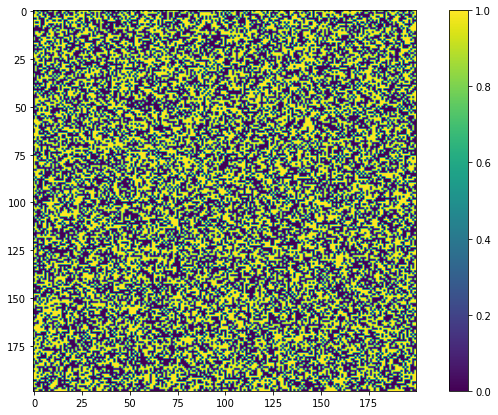

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('start2.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

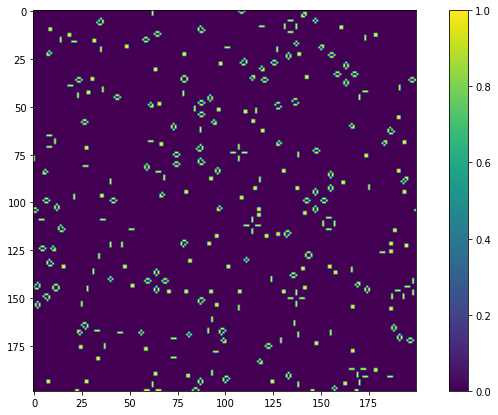

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('end2.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

In [ ]:
%%bash

nvprof ./test2 100000 200 200

==575== NVPROF is profiling process 575, command: ./test2 100000 200 200
==575== Profiling application: ./test2 100000 200 200
==575== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  1.27156s    100000  12.715us  12.416us  17.600us  runGeneration(int, int, int*, int*)
                    0.00%  31.231us         1  31.231us  31.231us  31.231us  [CUDA memcpy HtoD]
                    0.00%  26.336us         1  26.336us  26.336us  26.336us  [CUDA memcpy DtoH]
      API calls:   59.51%  2.73238s    100000  27.323us  3.2930us  19.959ms  cudaDeviceSynchronize
                   34.28%  1.57370s    100000  15.737us  4.2060us  14.083ms  cudaLaunchKernel
                    6.18%  283.60ms         1  283.60ms  283.60ms  283.60ms  cudaHostAlloc
                    0.01%  609.49us         1  609.49us  609.49us  609.49us  cuDeviceTotalMem
                    0.01%  311.62us        97  3.2120us     228ns  128.33us  cuDev

### Poniżej mapped memory

In [ ]:
%%writefile test3.cu
#include <cuda_runtime_api.h>
#include <cstdlib>
#include <iostream>
#include <fstream>
#include <string>
#include <time.h>


__device__ 
int getAgent(int x, int y, int width, int* cudaBoard) {
    return cudaBoard[y*width+x];
}

__device__
int calculateNeighbours(int x, int y, int width, int height, int *cudaBoard) {
    int n = 0;

    n += getAgent((x+width-1)%width, (y+height-1)%height, width, cudaBoard); // x-1, y-1
    n += getAgent(x, (y+height-1)%height, width, cudaBoard);                 // x,   y-1
    n += getAgent((x+1)%width, (y+height-1)%height, width, cudaBoard);       // x+1, y-1

    n += getAgent((x+width-1)%width, y, width, cudaBoard);                   // x-1, y
    n += getAgent((x+1)%width, y, width, cudaBoard);                         // x+1, y

    n += getAgent((x+width-1)%width, (y+1)%height, width, cudaBoard);        // x-1, y+1
    n += getAgent(x, (y+1)%height, width, cudaBoard);                        // x,   y+1
    n += getAgent((x+1)%width, (y+1)%height, width, cudaBoard);              // x+1, y+1

    return n;
}

__global__
void runGeneration(int width, int height, int *cudaBoardOld, int *cudaBoardNew) {
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;

    for(int i=index; i < width*height; i += stride) {
        int x = i%width;
        int y = i/width;

        int state = cudaBoardOld[i];
        int neighbours = calculateNeighbours(x, y, width, height, cudaBoardOld);
        
        
        if(state == 0 && neighbours == 3) {
            cudaBoardNew[i] = 1;
            continue;
        }
        if(state == 1 && (!(neighbours == 2 || neighbours == 3))) {
            cudaBoardNew[i] = 0;
            continue;
        }
        cudaBoardNew[i] = cudaBoardOld[i];
    }
}


void initializeBoard(int width, int height, int *board) {
    for(int i=0; i<width*height; ++i) 
        board[i] = rand() % 2;
}

void saveBoard(std::string name, int *localBoard, int width, int height) {
    std::ofstream MyFile(name);

    for(int x=0; x<width; ++x) {
        for(int y=0; y<height; ++y) {
            if(y != height-1)
                MyFile << localBoard[y*width+x] << ", ";
            else
                MyFile << localBoard[y*width+x];
        }
        MyFile << "\n";
    }

    MyFile.close();
}

int main(int argc, char** argv) {
    srand (time(NULL));
    int width = atoi(argv[2]);
    int height = atoi(argv[3]);
    int generations = atoi(argv[1]);
    int *cudaBoardOld, *cudaBoardNew;
    
    cudaHostAlloc(&cudaBoardOld, width*height*sizeof(int), cudaHostAllocMapped);
    cudaHostAlloc(&cudaBoardNew, width*height*sizeof(int), cudaHostAllocMapped);
    initializeBoard(width, height, cudaBoardOld);

    saveBoard("start3.txt", cudaBoardOld, width, height);

    int blockSize = 256;
    int numBlocks = (width*height + blockSize - 1) / blockSize;

    for(int i=0; i<generations; ++i) {
        runGeneration<<<numBlocks, blockSize>>>(width, height, cudaBoardOld, cudaBoardNew);
        cudaDeviceSynchronize();
        
        int *temp = cudaBoardOld;
        cudaBoardOld = cudaBoardNew;
        cudaBoardNew = temp;
    }

    saveBoard("end3.txt", cudaBoardOld, width, height);
    

    cudaFree(cudaBoardOld);
    cudaFree(cudaBoardNew);

    return 0;
}

Overwriting test3.cu


In [ ]:
%%bash

nvcc --std=c++11 test3.cu -o test3

In [ ]:
%%bash
./test3 100000 200 200

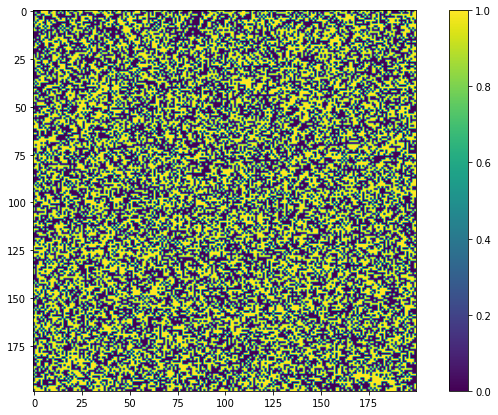

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('start3.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

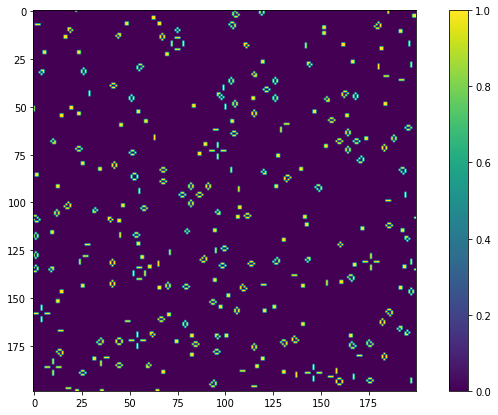

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('end3.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

In [ ]:
%%bash

nvprof ./test3 100000 200 200

==635== NVPROF is profiling process 635, command: ./test3 100000 200 200
==635== Profiling application: ./test3 100000 200 200
==635== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  24.6027s    100000  246.03us  222.27us  387.74us  runGeneration(int, int, int*, int*)
      API calls:   96.31%  25.4917s    100000  254.92us  5.3320us  9.5239ms  cudaDeviceSynchronize
                    2.94%  779.16ms    100000  7.7910us  4.3030us  861.15us  cudaLaunchKernel
                    0.75%  197.71ms         2  98.855ms  7.2460us  197.70ms  cudaHostAlloc
                    0.00%  451.24us         1  451.24us  451.24us  451.24us  cuDeviceTotalMem
                    0.00%  197.62us        97  2.0370us     121ns  83.707us  cuDeviceGetAttribute
                    0.00%  40.417us         1  40.417us  40.417us  40.417us  cuDeviceGetName
                    0.00%  7.3150us         1  7.3150us  7.3150us  7.3150us  cuDevi

### Poniżej managed memory

In [ ]:
%%writefile test4.cu
#include <cuda_runtime_api.h>
#include <cstdlib>
#include <iostream>
#include <fstream>
#include <string>
#include <time.h>


__device__ 
int getAgent(int x, int y, int width, int* cudaBoard) {
    return cudaBoard[y*width+x];
}

__device__
int calculateNeighbours(int x, int y, int width, int height, int *cudaBoard) {
    int n = 0;

    n += getAgent((x+width-1)%width, (y+height-1)%height, width, cudaBoard); // x-1, y-1
    n += getAgent(x, (y+height-1)%height, width, cudaBoard);                 // x,   y-1
    n += getAgent((x+1)%width, (y+height-1)%height, width, cudaBoard);       // x+1, y-1

    n += getAgent((x+width-1)%width, y, width, cudaBoard);                   // x-1, y
    n += getAgent((x+1)%width, y, width, cudaBoard);                         // x+1, y

    n += getAgent((x+width-1)%width, (y+1)%height, width, cudaBoard);        // x-1, y+1
    n += getAgent(x, (y+1)%height, width, cudaBoard);                        // x,   y+1
    n += getAgent((x+1)%width, (y+1)%height, width, cudaBoard);              // x+1, y+1

    return n;
}

__global__
void runGeneration(int width, int height, int *cudaBoardOld, int *cudaBoardNew) {
    int index = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;

    for(int i=index; i < width*height; i += stride) {
        int x = i%width;
        int y = i/width;

        int state = cudaBoardOld[i];
        int neighbours = calculateNeighbours(x, y, width, height, cudaBoardOld);
        
        
        if(state == 0 && neighbours == 3) {
            cudaBoardNew[i] = 1;
            continue;
        }
        if(state == 1 && (!(neighbours == 2 || neighbours == 3))) {
            cudaBoardNew[i] = 0;
            continue;
        }
        cudaBoardNew[i] = cudaBoardOld[i];
    }
}


void initializeBoard(int width, int height, int *board) {
    for(int i=0; i<width*height; ++i) 
        board[i] = rand() % 2;
}

void saveBoard(std::string name, int *localBoard, int width, int height) {
    std::ofstream MyFile(name);

    for(int x=0; x<width; ++x) {
        for(int y=0; y<height; ++y) {
            if(y != height-1)
                MyFile << localBoard[y*width+x] << ", ";
            else
                MyFile << localBoard[y*width+x];
        }
        MyFile << "\n";
    }

    MyFile.close();
}

int main(int argc, char** argv) {
    srand (time(NULL));
    int width = atoi(argv[2]);
    int height = atoi(argv[3]);
    int generations = atoi(argv[1]);
    int *cudaBoardOld, *cudaBoardNew;
    
    cudaMallocManaged(&cudaBoardOld, width*height*sizeof(int), cudaHostAllocMapped);
    cudaMallocManaged(&cudaBoardNew, width*height*sizeof(int), cudaHostAllocMapped);
    initializeBoard(width, height, cudaBoardOld);

    saveBoard("start4.txt", cudaBoardOld, width, height);

    int blockSize = 256;
    int numBlocks = (width*height + blockSize - 1) / blockSize;

    for(int i=0; i<generations; ++i) {
        runGeneration<<<numBlocks, blockSize>>>(width, height, cudaBoardOld, cudaBoardNew);
        cudaDeviceSynchronize();
        
        int *temp = cudaBoardOld;
        cudaBoardOld = cudaBoardNew;
        cudaBoardNew = temp;
    }

    saveBoard("end4.txt", cudaBoardOld, width, height);
    

    cudaFree(cudaBoardOld);
    cudaFree(cudaBoardNew);

    return 0;
}

Writing test4.cu


In [ ]:
%%bash

nvcc --std=c++11 test4.cu -o test4

In [ ]:
%%bash
./test4 100000 200 200

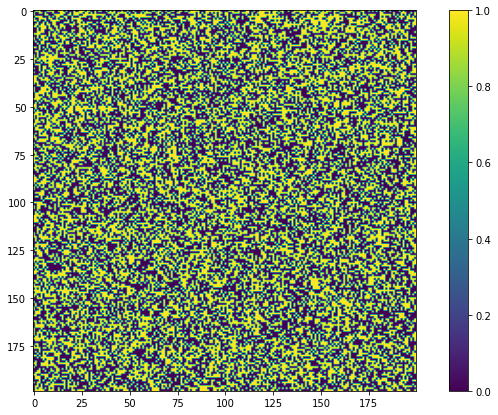

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('start4.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

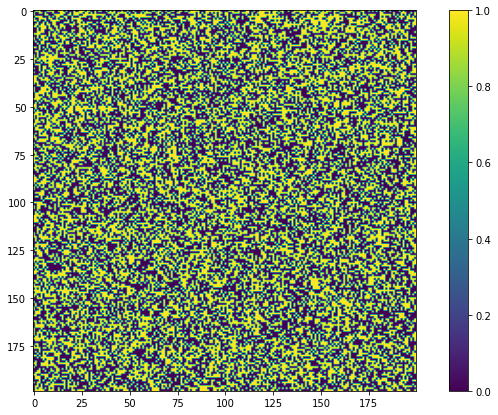

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('end4.txt')
data = df.to_numpy()
plt.figure(figsize=(12,7))
plt.imshow(data)
plt.colorbar()

In [ ]:
%%bash

nvprof ./test4 100000 200 200

==693== NVPROF is profiling process 693, command: ./test4 100000 200 200
==693== Profiling application: ./test4 100000 200 200
==693== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  1.27367s    100000  12.736us  12.447us  21.472us  runGeneration(int, int, int*, int*)
      API calls:   73.97%  7.19689s    100000  71.968us  27.351us  9.2851ms  cudaLaunchKernel
                   23.86%  2.32151s    100000  23.215us  7.0070us  257.65us  cudaDeviceSynchronize
                    2.16%  209.99ms         2  105.00ms  21.058us  209.97ms  cudaMallocManaged
                    0.00%  420.16us         1  420.16us  420.16us  420.16us  cuDeviceTotalMem
                    0.00%  264.53us         2  132.26us  69.148us  195.38us  cudaFree
                    0.00%  213.98us        97  2.2060us     128ns  105.00us  cuDeviceGetAttribute
                    0.00%  23.982us         1  23.982us  23.982us  23.982us  cuDeviceG